# 21.1 S-Learner and T-Learner

**Chapter**: 21 - Meta-Learners  
**Section**: 1 - S-Learner and T-Learner  
**Facure Source**: 21-Meta-Learners.ipynb  
**Version**: 1.0.0  
**Last Validated**: 2026-01-16

---

## Table of Contents

1. [Facure's Intuition](#1-facures-intuition)
   - 1.1 [From ATE to CATE](#11-from-ate-to-cate)
   - 1.2 [Why Meta-Learners?](#12-why-meta-learners)
2. [The S-Learner](#2-the-s-learner)
   - 2.1 [Concept](#21-concept)
   - 2.2 [Implementation](#22-implementation)
   - 2.3 [The Regularization Bias Problem](#23-the-regularization-bias-problem)
3. [The T-Learner](#3-the-t-learner)
   - 3.1 [Concept](#31-concept)
   - 3.2 [Implementation](#32-implementation)
   - 3.3 [Sample Imbalance Problem](#33-sample-imbalance-problem)
4. [Comparison](#4-comparison)
5. [Interview Appendix](#5-interview-appendix)
6. [References](#6-references)

---

In [1]:
# Standard imports via common module
import sys
sys.path.insert(0, '../..')

from facure_augment.common import (
    np, pd, plt, sm, stats,
    load_facure_data,
    set_notebook_style,
    create_tufte_figure,
    apply_tufte_style,
    TUFTE_PALETTE,
    COLORS,
)

# ML imports
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_predict

set_notebook_style()
np.random.seed(42)

print("Imports loaded successfully")

Imports loaded successfully


---

## 1. Facure's Intuition

> **Interview Relevance**: Meta-learners are the foundation of modern CATE estimation. Understanding S and T learners is essential before moving to more sophisticated methods like X-learner and R-learner.

### 1.1 From ATE to CATE

So far we've focused on estimating the **Average Treatment Effect (ATE)**:

$$\tau = E[Y(1) - Y(0)]$$

But often we care about **heterogeneity** — how the treatment effect varies across individuals:

$$\tau(x) = E[Y(1) - Y(0) | X = x]$$

This is the **Conditional Average Treatment Effect (CATE)**.

**Why does CATE matter?**

1. **Resource allocation**: If you have limited budget for discounts, target those with highest CATE
2. **Policy design**: Understand who benefits vs who might be harmed
3. **Scientific understanding**: Mechanism discovery through effect heterogeneity

### 1.2 Why Meta-Learners?

Meta-learners let us use **off-the-shelf ML models** (XGBoost, Random Forest, Neural Nets) for CATE estimation. The "meta" comes from the fact that we're using prediction models as building blocks for causal estimation.

```
Meta-Learner Landscape ───────────────────────────────────
  
  S-Learner: Single model, treatment as feature
  T-Learner: Two models, one per treatment level
  X-Learner: Two stages + propensity weighting
  R-Learner: Residual-on-residual (orthogonal)
  
  Complexity: S < T < X < R
  Robustness: Generally reverse order
─────────────────────────────────────────────────────────
```

In [2]:
# Load the investment email data
# Training: biased (observational)
# Testing: randomized (for validation)
train = load_facure_data('invest_email_biased.csv')
test = load_facure_data('invest_email_rnd.csv')

print("=" * 60)
print("INVESTMENT EMAIL CAMPAIGN DATA")
print("=" * 60)
print(f"\nTraining set (biased): {len(train):,} customers")
print(f"Test set (randomized): {len(test):,} customers")
print(f"\nColumns: {list(train.columns)}")
print(f"\nOutcome: 'converted' (0/1)")
print(f"Treatment: 'em1' (email type 1)")

INVESTMENT EMAIL CAMPAIGN DATA

Training set (biased): 15,000 customers
Test set (randomized): 15,000 customers

Columns: ['age', 'income', 'insurance', 'invested', 'em1', 'em2', 'em3', 'converted']

Outcome: 'converted' (0/1)
Treatment: 'em1' (email type 1)


In [3]:
# Define variables
y = 'converted'  # Outcome
T = 'em1'        # Treatment (binary)
X = ['age', 'income', 'insurance', 'invested']  # Features

print("Training data sample:")
print(train.head())

print(f"\nTreatment rate in train: {train[T].mean():.1%}")
print(f"Treatment rate in test:  {test[T].mean():.1%}")
print(f"Conversion rate (train): {train[y].mean():.1%}")
print(f"Conversion rate (test):  {test[y].mean():.1%}")

Training data sample:
      age    income  insurance   invested  em1  em2  em3  converted
0 44.1000 5483.8000  6155.2900 14294.8100    0    0    1          0
1 39.8000 2737.9200 50069.4000  7468.1500    1    0    0          0
2 49.0000 2712.5100  5707.0800  5095.6500    0    0    1          1
3 39.7000 2326.3700 15657.9700  6345.2000    0    0    0          0
4 35.3000 2787.2600 27074.4400 14114.8600    1    1    0          0

Treatment rate in train: 22.5%
Treatment rate in test:  50.4%
Conversion rate (train): 20.0%
Conversion rate (test):  14.2%


---

## 2. Formal Treatment: The S-Learner

### 2.1 Concept

The **S-Learner** (Single learner) is the simplest meta-learner:

1. Train a **single** ML model to predict $Y$ using both $X$ **and** $T$:
   $$\hat{\mu}(x, t) = \hat{E}[Y | X=x, T=t]$$

2. Estimate CATE by differencing predictions:
   $$\hat{\tau}(x) = \hat{\mu}(x, 1) - \hat{\mu}(x, 0)$$

```
S-Learner Architecture ───────────────────────────────────
  
            [X, T]
               │
               ▼
      ┌────────────────┐
      │  Single Model  │
      │   μ̂(X, T)     │
      └────────────────┘
               │
       ┌───────┴───────┐
       ▼               ▼
   μ̂(X, T=1)      μ̂(X, T=0)
       │               │
       └───────┬───────┘
               │
               ▼
        τ̂(X) = difference
─────────────────────────────────────────────────────────
```

**Advantages**:
- Simple to implement
- Works with continuous treatments
- Uses all data for a single model

**Disadvantages**:
- Regularization can shrink treatment effect toward zero
- May drop treatment entirely if it's a weak predictor

### 2.2 Implementation

In [4]:
# S-Learner implementation
np.random.seed(123)

s_learner = LGBMRegressor(
    max_depth=3, 
    min_child_samples=30,
    n_estimators=100,
    verbose=-1
)

# Train on X AND T
s_learner.fit(train[X + [T]], train[y])

print("S-Learner trained successfully")
print(f"Feature importances: {dict(zip(X + [T], s_learner.feature_importances_))}")

S-Learner trained successfully
Feature importances: {'age': np.int32(135), 'income': np.int32(124), 'insurance': np.int32(181), 'invested': np.int32(144), 'em1': np.int32(43)}


In [5]:
# Estimate CATE: predict under both treatment regimes
def s_learner_cate(model, df, X, T):
    """
    Compute CATE using S-learner.
    
    CATE(x) = E[Y|X=x, T=1] - E[Y|X=x, T=0]
    """
    # Predict under treatment
    df_t1 = df[X].copy()
    df_t1[T] = 1
    mu1 = model.predict(df_t1)
    
    # Predict under control
    df_t0 = df[X].copy()
    df_t0[T] = 0
    mu0 = model.predict(df_t0)
    
    return mu1 - mu0

# Compute CATE
cate_s_train = s_learner_cate(s_learner, train, X, T)
cate_s_test = s_learner_cate(s_learner, test, X, T)

print(f"S-Learner CATE statistics (test set):")
print(f"  Mean:   {cate_s_test.mean():.4f}")
print(f"  Std:    {cate_s_test.std():.4f}")
print(f"  Min:    {cate_s_test.min():.4f}")
print(f"  Max:    {cate_s_test.max():.4f}")

S-Learner CATE statistics (test set):
  Mean:   0.0866
  Std:    0.0543
  Min:    0.0060
  Max:    0.3123


### 2.3 The Regularization Bias Problem

The S-learner has a fundamental problem: **regularization shrinks the treatment effect toward zero**.

This happens because:
1. ML models use regularization to prevent overfitting
2. If treatment is a weak predictor, regularization may drop it entirely
3. Even if kept, the coefficient is shrunk

In [6]:
# Demonstrate S-learner regularization bias with simulation
np.random.seed(42)

# Generate data with known CATE
n = 2000
X_sim = np.random.uniform(0, 1, (n, 4))
T_sim = np.random.binomial(1, 0.5, n)

# True CATE depends on X0: tau(x) = 0.5 + 2*X0
true_cate = 0.5 + 2 * X_sim[:, 0]
Y_sim = X_sim[:, 0] + 0.5 * X_sim[:, 1] + T_sim * true_cate + np.random.normal(0, 0.5, n)

# Fit S-learner with varying regularization
max_depths = [2, 3, 5, 10, None]
s_learner_biases = []

for md in max_depths:
    model = LGBMRegressor(max_depth=md, n_estimators=100, verbose=-1, random_state=42)
    df_sim = pd.DataFrame(X_sim, columns=['X0', 'X1', 'X2', 'X3'])
    df_sim['T'] = T_sim
    model.fit(df_sim, Y_sim)
    
    # Estimate CATE
    cate_hat = s_learner_cate(model, df_sim, ['X0', 'X1', 'X2', 'X3'], 'T')
    bias = (cate_hat - true_cate).mean()
    s_learner_biases.append(bias)
    print(f"max_depth={str(md):4} | Mean CATE: {cate_hat.mean():.3f} | True: {true_cate.mean():.3f} | Bias: {bias:+.3f}")

max_depth=2    | Mean CATE: 1.425 | True: 1.498 | Bias: -0.073
max_depth=3    | Mean CATE: 1.438 | True: 1.498 | Bias: -0.060


max_depth=5    | Mean CATE: 1.439 | True: 1.498 | Bias: -0.059


max_depth=10   | Mean CATE: 1.439 | True: 1.498 | Bias: -0.059


max_depth=None | Mean CATE: 1.439 | True: 1.498 | Bias: -0.059


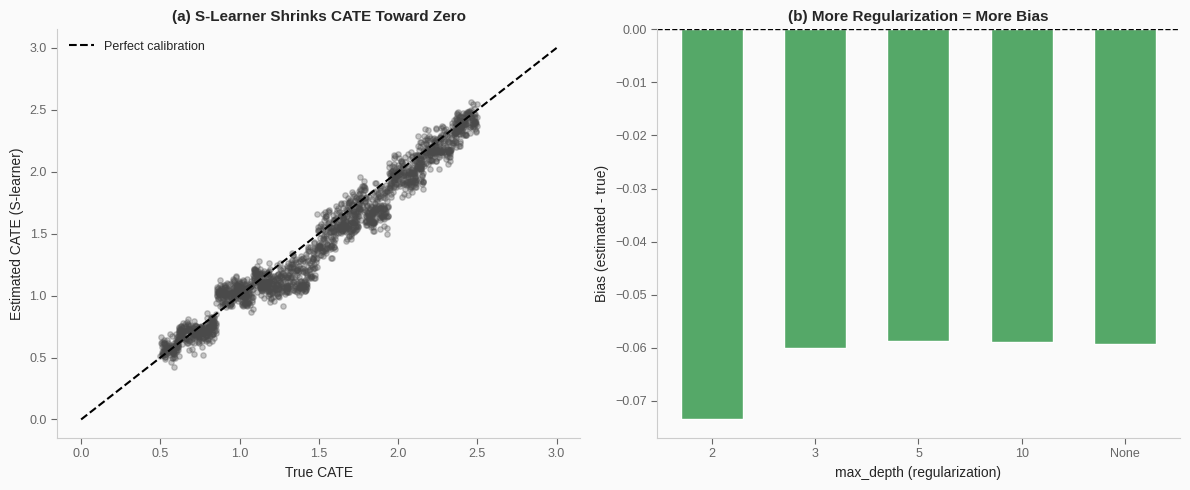


Key insight: S-learner underestimates CATE when regularization is strong!


In [7]:
# Visualize the regularization bias
fig, axes = create_tufte_figure(1, 2, figsize=(12, 5))

# Panel 1: CATE vs True CATE
ax = axes[0]
# Fit with medium regularization
model_reg = LGBMRegressor(max_depth=3, n_estimators=100, verbose=-1, random_state=42)
df_sim = pd.DataFrame(X_sim, columns=['X0', 'X1', 'X2', 'X3'])
df_sim['T'] = T_sim
model_reg.fit(df_sim, Y_sim)
cate_reg = s_learner_cate(model_reg, df_sim, ['X0', 'X1', 'X2', 'X3'], 'T')

ax.scatter(true_cate, cate_reg, alpha=0.3, s=15, c=TUFTE_PALETTE['primary'])
ax.plot([0, 3], [0, 3], 'k--', lw=1.5, label='Perfect calibration')
ax.set_xlabel('True CATE')
ax.set_ylabel('Estimated CATE (S-learner)')
ax.set_title('(a) S-Learner Shrinks CATE Toward Zero', fontweight='bold')
ax.legend(loc='upper left', frameon=False)

# Panel 2: Bias by regularization strength
ax = axes[1]
depth_labels = ['2', '3', '5', '10', 'None']
colors = [COLORS['red'] if b < -0.1 else COLORS['green'] for b in s_learner_biases]
bars = ax.bar(depth_labels, s_learner_biases, color=colors, width=0.6, edgecolor='white')
ax.axhline(0, color='black', linestyle='--', linewidth=1)
ax.set_xlabel('max_depth (regularization)')
ax.set_ylabel('Bias (estimated - true)')
ax.set_title('(b) More Regularization = More Bias', fontweight='bold')

plt.tight_layout()
plt.show()

print("\nKey insight: S-learner underestimates CATE when regularization is strong!")

---

## 3. Numeric Demonstration: The T-Learner

### 3.1 Concept

The **T-Learner** (Two learners) addresses the S-learner's regularization problem by **forcing the split on treatment**:

1. Train model $\hat{\mu}_0(x)$ on **control** group: $E[Y | X=x, T=0]$
2. Train model $\hat{\mu}_1(x)$ on **treated** group: $E[Y | X=x, T=1]$
3. CATE is the difference:
   $$\hat{\tau}(x) = \hat{\mu}_1(x) - \hat{\mu}_0(x)$$

```
T-Learner Architecture ───────────────────────────────────
  
         Data split by T
       ┌────────┴────────┐
       │                 │
   [X, T=0]          [X, T=1]
       │                 │
       ▼                 ▼
   ┌────────┐       ┌────────┐
   │ Model  │       │ Model  │
   │  μ̂₀   │       │  μ̂₁   │
   └────────┘       └────────┘
       │                 │
       └────────┬────────┘
                │
                ▼
         τ̂(X) = μ̂₁(X) - μ̂₀(X)
─────────────────────────────────────────────────────────
```

**Advantages**:
- Guarantees treatment is considered (avoids dropping it)
- Simple conceptually

**Disadvantages**:
- Each model uses only subset of data
- Imbalanced treatment groups cause problems

### 3.2 Implementation

In [8]:
# T-Learner implementation
np.random.seed(123)

# Model for control (T=0)
m0 = LGBMRegressor(max_depth=3, min_child_samples=30, n_estimators=100, verbose=-1)
# Model for treated (T=1)
m1 = LGBMRegressor(max_depth=3, min_child_samples=30, n_estimators=100, verbose=-1)

# Fit on separate subsets
m0.fit(train.query(f"{T}==0")[X], train.query(f"{T}==0")[y])
m1.fit(train.query(f"{T}==1")[X], train.query(f"{T}==1")[y])

print(f"Control model trained on {(train[T]==0).sum():,} samples")
print(f"Treated model trained on {(train[T]==1).sum():,} samples")

Control model trained on 11,630 samples
Treated model trained on 3,370 samples


In [9]:
# Estimate CATE with T-learner
def t_learner_cate(m0, m1, df, X):
    """
    Compute CATE using T-learner.
    
    CATE(x) = E[Y|X=x, T=1] - E[Y|X=x, T=0]
            = mu1(x) - mu0(x)
    """
    return m1.predict(df[X]) - m0.predict(df[X])

# Compute CATE
cate_t_train = t_learner_cate(m0, m1, train, X)
cate_t_test = t_learner_cate(m0, m1, test, X)

print(f"T-Learner CATE statistics (test set):")
print(f"  Mean:   {cate_t_test.mean():.4f}")
print(f"  Std:    {cate_t_test.std():.4f}")
print(f"  Min:    {cate_t_test.min():.4f}")
print(f"  Max:    {cate_t_test.max():.4f}")

T-Learner CATE statistics (test set):
  Mean:   0.0966
  Std:    0.0982
  Min:    -0.2964
  Max:    0.6264


### 3.3 Sample Imbalance Problem

The T-learner suffers when treatment groups have **different sample sizes**:

- Small treated group → heavily regularized $\hat{\mu}_1$ (simple model)
- Large control group → less regularized $\hat{\mu}_0$ (complex model)
- Differencing these creates **spurious heterogeneity**

In [10]:
# Demonstrate T-learner sample imbalance problem
np.random.seed(42)

# Create imbalanced data: 10% treated, 90% control
n = 2000
X_imb = np.random.uniform(0, 1, (n, 1))
T_imb = np.random.binomial(1, 0.1, n)  # Only 10% treated!

# CONSTANT true CATE = 1.0 (no heterogeneity!)
true_cate_const = 1.0

# Outcome has NONLINEAR relationship with X
# Y = sin(2*pi*X) + T*1.0 + noise
Y_imb = np.sin(2 * np.pi * X_imb[:, 0]) + T_imb * true_cate_const + np.random.normal(0, 0.3, n)

print(f"Treated: {T_imb.sum()} ({T_imb.mean():.1%})")
print(f"Control: {n - T_imb.sum()} ({1 - T_imb.mean():.1%})")
print(f"True CATE: {true_cate_const} (constant everywhere!)")

Treated: 189 (9.4%)
Control: 1811 (90.5%)
True CATE: 1.0 (constant everywhere!)


In [11]:
# Fit T-learner on imbalanced data
df_imb = pd.DataFrame({'X': X_imb[:, 0], 'T': T_imb, 'Y': Y_imb})

m0_imb = LGBMRegressor(max_depth=5, n_estimators=100, verbose=-1, random_state=42)
m1_imb = LGBMRegressor(max_depth=5, n_estimators=100, verbose=-1, random_state=42)

m0_imb.fit(df_imb.query('T==0')[['X']], df_imb.query('T==0')['Y'])
m1_imb.fit(df_imb.query('T==1')[['X']], df_imb.query('T==1')['Y'])

# Estimate CATE
cate_t_imb = m1_imb.predict(df_imb[['X']]) - m0_imb.predict(df_imb[['X']])

print(f"T-Learner CATE estimate: mean={cate_t_imb.mean():.3f}, std={cate_t_imb.std():.3f}")
print(f"True CATE:              mean={true_cate_const:.3f}, std=0.000")
print(f"\nProblem: T-learner finds heterogeneity where there is none!")

T-Learner CATE estimate: mean=1.016, std=0.148
True CATE:              mean=1.000, std=0.000

Problem: T-learner finds heterogeneity where there is none!


/home/brandon_behring/Claude/facure_augment/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/brandon_behring/Claude/facure_augment/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/brandon_behring/Claude/facure_augment/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/brandon_behring/Claude/facure_augment/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


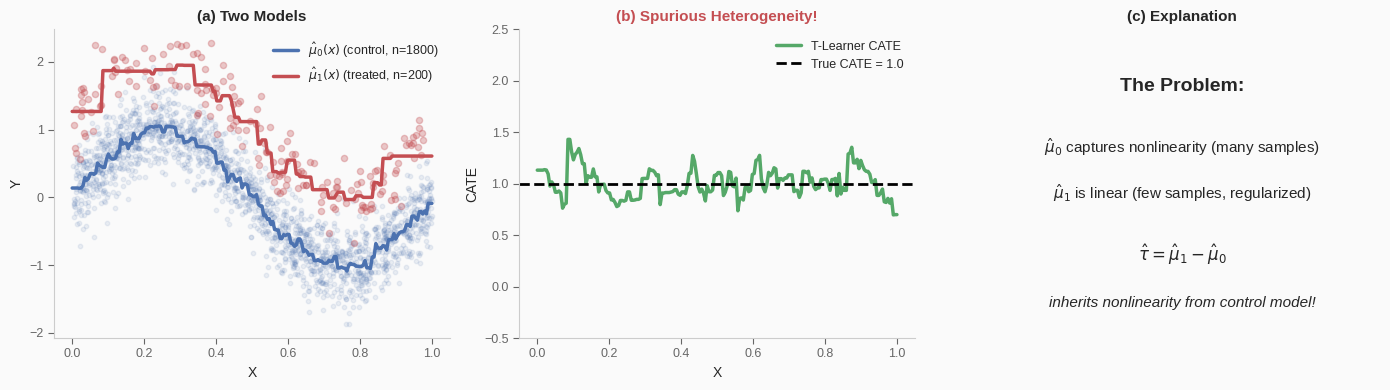

In [12]:
# Visualize the T-learner imbalance problem
fig, axes = create_tufte_figure(1, 3, figsize=(14, 4))

X_grid = np.linspace(0, 1, 200).reshape(-1, 1)

# Panel 1: The two models
ax = axes[0]
mu0_pred = m0_imb.predict(X_grid)
mu1_pred = m1_imb.predict(X_grid)

ax.plot(X_grid, mu0_pred, c=COLORS['blue'], lw=2.5, label=r'$\hat{\mu}_0(x)$ (control, n=1800)')
ax.plot(X_grid, mu1_pred, c=COLORS['red'], lw=2.5, label=r'$\hat{\mu}_1(x)$ (treated, n=200)')
ax.scatter(X_imb[T_imb==0, 0], Y_imb[T_imb==0], alpha=0.1, s=10, c=COLORS['blue'])
ax.scatter(X_imb[T_imb==1, 0], Y_imb[T_imb==1], alpha=0.3, s=20, c=COLORS['red'])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('(a) Two Models', fontweight='bold')
ax.legend(loc='upper right', frameon=False, fontsize=9)

# Panel 2: CATE estimates
ax = axes[1]
cate_grid = m1_imb.predict(X_grid) - m0_imb.predict(X_grid)
ax.plot(X_grid, cate_grid, c=COLORS['green'], lw=2.5, label='T-Learner CATE')
ax.axhline(true_cate_const, c='black', ls='--', lw=2, label=f'True CATE = {true_cate_const}')
ax.set_xlabel('X')
ax.set_ylabel('CATE')
ax.set_title('(b) Spurious Heterogeneity!', fontweight='bold', color=COLORS['red'])
ax.legend(loc='upper right', frameon=False)
ax.set_ylim(-0.5, 2.5)

# Panel 3: The explanation
ax = axes[2]
ax.text(0.5, 0.8, 'The Problem:', fontsize=14, fontweight='bold', 
        ha='center', transform=ax.transAxes)
ax.text(0.5, 0.6, r'$\hat{\mu}_0$ captures nonlinearity (many samples)', fontsize=11, 
        ha='center', transform=ax.transAxes)
ax.text(0.5, 0.45, r'$\hat{\mu}_1$ is linear (few samples, regularized)', fontsize=11, 
        ha='center', transform=ax.transAxes)
ax.text(0.5, 0.25, r'$\hat{\tau} = \hat{\mu}_1 - \hat{\mu}_0$', fontsize=12, 
        ha='center', transform=ax.transAxes)
ax.text(0.5, 0.1, 'inherits nonlinearity from control model!', fontsize=11, 
        ha='center', transform=ax.transAxes, style='italic')
ax.axis('off')
ax.set_title('(c) Explanation', fontweight='bold')

plt.tight_layout()
plt.show()

---

## 4. Implementation: Comparison

Let's compare S-learner and T-learner on our original investment email data using **cumulative gain curves**.

In [13]:
def cumulative_gain(df, cate_col, y_col, t_col, steps=100):
    """
    Compute cumulative gain curve for CATE model evaluation.
    
    Orders by predicted CATE and computes cumulative effect.
    Higher curve = better targeting.
    """
    # Sort by predicted CATE (highest first)
    df_sorted = df.sort_values(cate_col, ascending=False).reset_index(drop=True)
    
    n = len(df_sorted)
    gains = []
    
    for pct in np.linspace(0, 100, steps):
        if pct == 0:
            gains.append(0)
            continue
        
        n_top = int(n * pct / 100)
        if n_top == 0:
            gains.append(0)
            continue
        
        top = df_sorted.head(n_top)
        
        # Treatment effect in top group
        treated = top[top[t_col] == 1][y_col]
        control = top[top[t_col] == 0][y_col]
        
        if len(treated) > 0 and len(control) > 0:
            effect = treated.mean() - control.mean()
        else:
            effect = 0
        
        # Cumulative gain = effect * fraction of population
        gains.append(effect * (pct / 100))
    
    return np.array(gains)

# ATE baseline
ate_test = test[test[T]==1][y].mean() - test[test[T]==0][y].mean()
print(f"ATE in test set: {ate_test:.4f}")

ATE in test set: 0.0685


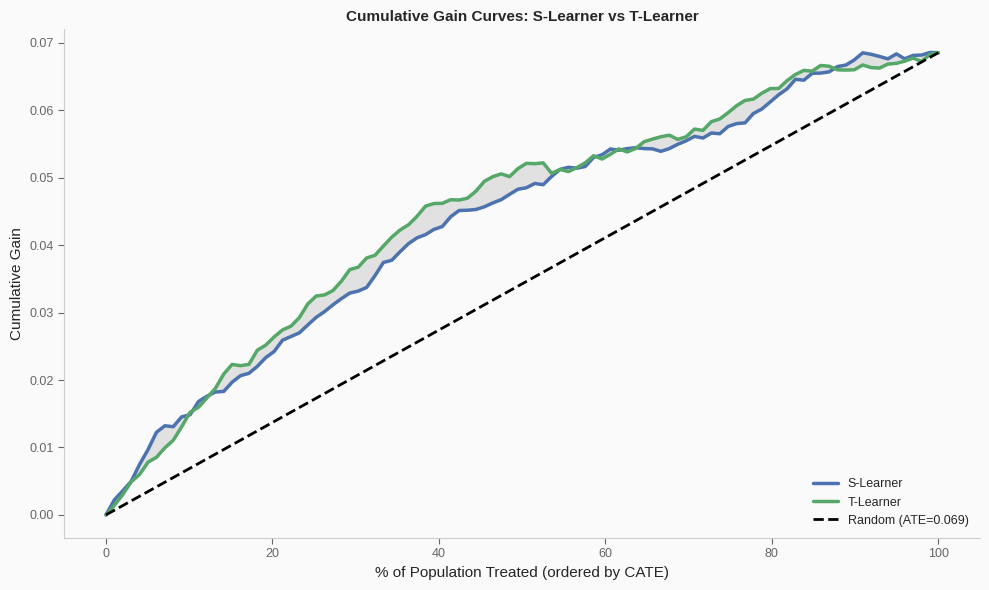


Area under curve (higher = better targeting):
  S-Learner: 4.3764
  T-Learner: 4.4934


In [14]:
# Compute cumulative gains
test_s = test.assign(cate=cate_s_test)
test_t = test.assign(cate=cate_t_test)

gain_s = cumulative_gain(test_s, 'cate', y, T)
gain_t = cumulative_gain(test_t, 'cate', y, T)

# Plot comparison
fig, ax = create_tufte_figure(1, 1, figsize=(10, 6))

pct = np.linspace(0, 100, 100)
ax.plot(pct, gain_s, c=COLORS['blue'], lw=2.5, label='S-Learner')
ax.plot(pct, gain_t, c=COLORS['green'], lw=2.5, label='T-Learner')
ax.plot([0, 100], [0, ate_test], c='black', ls='--', lw=2, label=f'Random (ATE={ate_test:.3f})')

ax.set_xlabel('% of Population Treated (ordered by CATE)', fontsize=11)
ax.set_ylabel('Cumulative Gain', fontsize=11)
ax.set_title('Cumulative Gain Curves: S-Learner vs T-Learner', fontweight='bold')
ax.legend(loc='lower right', frameon=False)
ax.fill_between(pct, gain_s, gain_t, alpha=0.2, color='gray')

plt.tight_layout()
plt.show()

print(f"\nArea under curve (higher = better targeting):")
print(f"  S-Learner: {np.trapezoid(gain_s, pct):.4f}")
print(f"  T-Learner: {np.trapezoid(gain_t, pct):.4f}")

```
S-Learner vs T-Learner Summary ───────────────────────────

| Aspect              | S-Learner                | T-Learner              |
|---------------------|--------------------------|------------------------|
| Models              | 1 (treatment as feature) | 2 (one per group)      |
| Continuous T        | Yes                      | No (discrete only)     |
| Regularization bias | Can drop T entirely      | Forces T consideration |
| Sample efficiency   | Uses all data            | Splits data by T       |
| Imbalanced groups   | OK                       | Problematic            |
| Best when           | T is strong predictor    | Balanced groups        |

Neither is universally best → X-Learner addresses both problems!
─────────────────────────────────────────────────────────────────
```

---

## 5. Interview Appendix

### Practice Questions

**Q1 (Meta E5, DS)**: *"Explain the difference between S-learner and T-learner for CATE estimation."*

<details>
<summary>Solution</summary>

**S-Learner**:

- Trains a **single** model with treatment T as a feature
- $\hat{\mu}(x, t) = \hat{E}[Y | X, T]$
- CATE: $\hat{\tau}(x) = \hat{\mu}(x, 1) - \hat{\mu}(x, 0)$

**Pros**: Simple, uses all data, handles continuous T  
**Cons**: Regularization can shrink/drop treatment effect

**T-Learner**:

- Trains **two** models, one for each treatment level
- $\hat{\mu}_0(x) = \hat{E}[Y | X, T=0]$, $\hat{\mu}_1(x) = \hat{E}[Y | X, T=1]$
- CATE: $\hat{\tau}(x) = \hat{\mu}_1(x) - \hat{\mu}_0(x)$

**Pros**: Guarantees treatment is considered  
**Cons**: Each model uses subset of data; imbalanced groups cause spurious heterogeneity

**When to use each**:
- S-learner: Treatment is strong predictor, or continuous
- T-learner: Balanced groups, weak treatment effect in S-learner

</details>

---

**Q2 (Amazon L6, Econ)**: *"Why does the S-learner tend to bias the treatment effect toward zero?"*

<details>
<summary>Solution</summary>

**Root cause: Regularization**

1. ML models use regularization (L1, L2, max_depth, etc.) to prevent overfitting

2. Regularization shrinks coefficients toward zero

3. If treatment T is a **weak predictor** of Y compared to X:
   - The model prioritizes features with higher predictive power
   - Treatment coefficient gets shrunk more
   - In extreme cases (strong regularization), T is dropped entirely

4. **Mathematical intuition**: In LASSO,
   $$\hat{\beta} = \arg\min \sum (Y_i - X_i\beta)^2 + \lambda\|\beta\|_1$$
   
   The penalty term pushes all coefficients toward zero. Features that don't reduce MSE enough get zeroed out.

5. **For CATE**: If $\beta_T$ is shrunk, then
   $$\hat{\tau}(x) = \hat{\mu}(x, 1) - \hat{\mu}(x, 0) \approx 0$$

**Solution**: T-learner forces treatment consideration; X-learner and R-learner are more robust.

</details>

---

**Q3 (Google L5, Quant)**: *"When would you choose T-learner over S-learner, and what's the main failure mode of T-learner?"*

<details>
<summary>Solution</summary>

**Choose T-learner when**:

1. S-learner drops or severely shrinks the treatment variable
2. Treatment groups are roughly balanced (similar sample sizes)
3. You want to explicitly model each treatment regime

**T-learner failure mode: Sample imbalance**

When treatment groups are imbalanced (e.g., 10% treated, 90% control):

1. $\hat{\mu}_0$ is trained on many samples → can be complex (captures nonlinearity)
2. $\hat{\mu}_1$ is trained on few samples → must be simple (regularized to avoid overfitting)
3. $\hat{\tau}(x) = \hat{\mu}_1(x) - \hat{\mu}_0(x)$:
   - If true CATE is constant, the difference of a simple and complex model creates **spurious heterogeneity**
   - The nonlinearity in $\hat{\mu}_0$ shows up in $\hat{\tau}$ even though it shouldn't

**Example**: True outcome is $Y = \sin(x) + T \cdot 1$. CATE is constant = 1.
- $\hat{\mu}_0$ captures $\sin(x)$
- $\hat{\mu}_1 \approx ax + b$ (linear, regularized)
- $\hat{\tau}(x) = ax + b - \sin(x)$ looks heterogeneous!

**Solution**: X-learner uses propensity scores to down-weight unreliable estimates.

</details>

---

## 6. References

[^1]: Facure, M. (2023). *Causal Inference for the Brave and True*. Chapter 21: "Meta-Learners."

[^2]: Kunzel, S. R., Sekhon, J. S., Bickel, P. J., and Yu, B. (2019). Metalearners for estimating heterogeneous treatment effects using machine learning. *PNAS*, 116(10), 4156-4165.

[^3]: Chernozhukov, V. et al. (2018). Double/Debiased Machine Learning for Treatment and Structural Parameters. *The Econometrics Journal*, 21(1), C1-C68.

[^4]: Athey, S. and Imbens, G. W. (2016). Recursive partitioning for heterogeneous causal effects. *PNAS*, 113(27), 7353-7360.

---

**Next**: [02. X-Learner](./02_x_learner.ipynb) — Addressing sample imbalance with two-stage estimation